In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("drive/MyDrive/energycons/AEP_hourly.csv")
dataset = df
dataset["Month"] = pd.to_datetime(df["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["Datetime"]).dt.year
dataset["Date"] = pd.to_datetime(df["Datetime"]).dt.date
#dataset["Time"] = pd.to_datetime(df["Datetime"], errors='coerce').dt.time
dataset['Time'] = pd.to_datetime(df['Datetime']).dt.strftime('%H:%M:%S')
dataset["Week"] = pd.to_datetime(df["Datetime"]).dt.week
dataset["Day"] = pd.to_datetime(df["Datetime"]).dt.day_name()
dataset = df.set_index("Datetime")
dataset.index = pd.to_datetime(dataset.index)
"""
dataset.head(1)
fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

plt.style.use('ggplot')
sns.lineplot(x='Date',y='AEP_MW', data=df)
plt.title("Energy Consumption vs Time ")
plt.xlabel("Time")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)
"""


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


'\ndataset.head(1)\nfig = plt.figure()\nax1 = plt.subplot2grid((1,1), (0,0))\n\nplt.style.use(\'ggplot\')\nsns.lineplot(x=\'Date\',y=\'AEP_MW\', data=df)\nplt.title("Energy Consumption vs Time ")\nplt.xlabel("Time")\nplt.grid(True, alpha=1)\nplt.legend()\n\nfor label in ax1.xaxis.get_ticklabels():\n    label.set_rotation(90)\n'

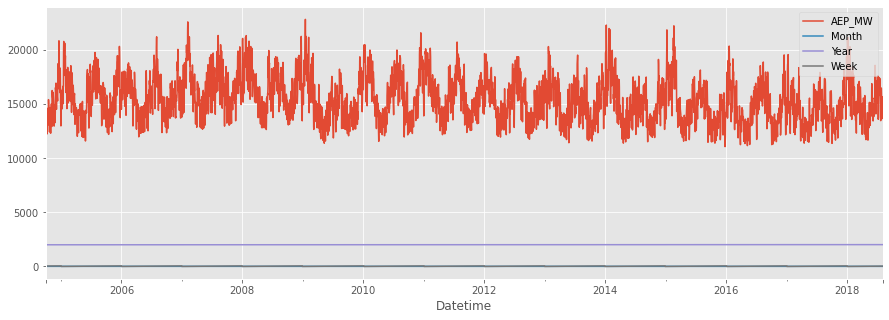

In [ ]:
NewDataSet = dataset.resample('D').mean()
NewDataSet.plot(figsize=(15,5))

In [ ]:
NewDataSet = dataset.resample('D').mean()
TestData = NewDataSet.tail(100)

Training_Set = NewDataSet.iloc[:,0:1]

Training_Set = Training_Set[:-60]

In [ ]:
print("Training Set Shape ", Training_Set.shape)
print("Test Set Shape ", TestData.shape)

Training Set Shape  (4995, 1)
Test Set Shape  (100, 4)


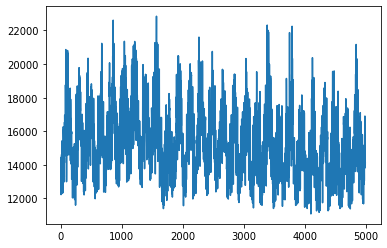

In [ ]:
plt.plot(np.linspace(1,4995,4995),Training_Set)

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
Train = sc.fit_transform(Training_Set)

In [ ]:
X_Train = []
Y_Train = []

# Range should be fromm 60 Values to END 
for i in range(60, Train.shape[0]):
    
    # X_Train 0-59 
    X_Train.append(Train[i-60:i])
    
    # Y Would be 60 th Value based on past 60 Values 
    Y_Train.append(Train[i])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(4935, 60, 1)
(4935, 1)


In [ ]:
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))
X_Train.shape

(4935, 60, 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout

In [ ]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_Train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_Train, Y_Train, epochs = 50, batch_size = 32)

Epoch 1/50
155/155 [==============================] - 30s 128ms/step - loss: 0.0229
Epoch 2/50
155/155 [==============================] - 20s 128ms/step - loss: 0.0186
Epoch 3/50
155/155 [==============================] - 20s 131ms/step - loss: 0.0173
Epoch 4/50
155/155 [==============================] - 21s 135ms/step - loss: 0.0166
Epoch 5/50
155/155 [==============================] - 20s 130ms/step - loss: 0.0156
Epoch 6/50
155/155 [==============================] - 20s 128ms/step - loss: 0.0155
Epoch 7/50
155/155 [==============================] - 20s 127ms/step - loss: 0.0150
Epoch 8/50
155/155 [==============================] - 20s 127ms/step - loss: 0.0146
Epoch 9/50
155/155 [==============================] - 20s 127ms/step - loss: 0.0123
Epoch 10/50
155/155 [==============================] - 20s 127ms/step - loss: 0.0106
Epoch 11/50
155/155 [==============================] - 22s 143ms/step - loss: 0.0096
Epoch 12/50
155/155 [==============================] - 20s 130ms/step - lo

In [ ]:
Df_Total = pd.concat((NewDataSet[["AEP_MW"]], TestData[["AEP_MW"]]), axis=0)

In [ ]:
inputs = Df_Total[len(Df_Total) - len(TestData) - 60:].values
inputs.shape

(160, 1)

In [ ]:
inputs = inputs.reshape(-1,1)

# Normalize the Dataset
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 160):
    X_test.append(inputs[i-60:i])
    
# Convert into Numpy Array
X_test = np.array(X_test)

# Reshape before Passing to Network
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Pass to Model 
predicted_MegaWatt = regressor.predict(X_test)

# Do inverse Transformation to get Values 
predicted_MegaWatt = sc.inverse_transform(predicted_MegaWatt)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
True_MegaWatt = TestData["AEP_MW"].to_list()
dates = TestData.index.to_list()

In [ ]:
Machine_Df = pd.DataFrame(data={
    "Date":dates,
    "TrueMegaWatt": True_MegaWatt,
    "PredictedMeagWatt":[x[0] for x in predicted_MegaWatt ]
})

No handles with labels found to put in legend.


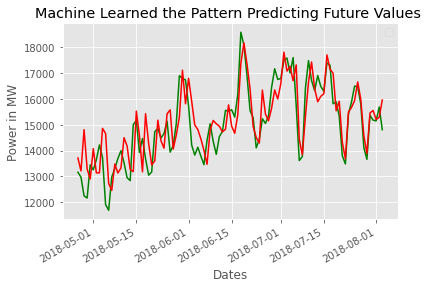

In [ ]:
fig = plt.figure()

ax1= fig.add_subplot(111)

x = dates
y = True_MegaWatt

y1 = predicted_MegaWatt

plt.plot(x,y, color="green")
plt.plot(x,y1, color="red")
# beautify the x-labels
plt.rcParams["figure.figsize"] = (18,8)
plt.gcf().autofmt_xdate()
plt.xlabel('Dates')
plt.ylabel("Power in MW")
plt.title("Machine Learned the Pattern Predicting Future Values ")
plt.legend()


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/energycons/diffeq1')


In [ ]:
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



from torchdiffeq import odeint


def generate_spiral2d(nspiral=1000,
                      ntotal=500,
                      nsample=100,
                      start=0.,
                      stop=1,  # approximately equal to 6pi
                      noise_std=.1,
                      a=0.,
                      b=1.,
                      savefig=True):
    """Parametric formula for 2d spiral is `r = a + b * theta`.
    Args:
      nspiral: number of spirals, i.e. batch dimension
      ntotal: total number of datapoints per spiral
      nsample: number of sampled datapoints for model fitting per spiral
      start: spiral starting theta value
      stop: spiral ending theta value
      noise_std: observation noise standard deviation
      a, b: parameters of the Archimedean spiral
      savefig: plot the ground truth for sanity check
    Returns: 
      Tuple where first element is true trajectory of size (nspiral, ntotal, 2),
      second element is noisy observations of size (nspiral, nsample, 2),
      third element is timestamps of size (ntotal,),
      and fourth element is timestamps of size (nsample,)
    """

    # add 1 all timestamps to avoid division by 0
    orig_ts = np.linspace(start, stop, num=ntotal)
    samp_ts = orig_ts[:nsample]

    # generate clock-wise and counter clock-wise spirals in observation space
    # with two sets of time-invariant latent dynamics
    zs_cw = stop + 1. - orig_ts
    rs_cw = a + b * 50. / zs_cw
    xs, ys = rs_cw * np.cos(zs_cw) - 5., rs_cw * np.sin(zs_cw)
    orig_traj_cw = np.stack((xs, ys), axis=1)

    zs_cc = orig_ts
    rw_cc = a + b * zs_cc
    xs, ys = rw_cc * np.cos(zs_cc) + 5., rw_cc * np.sin(zs_cc)
    orig_traj_cc = np.stack((xs, ys), axis=1)

    if savefig:
        plt.figure()
        plt.plot(orig_traj_cw[:, 0], orig_traj_cw[:, 1], label='clock')
        plt.plot(orig_traj_cc[:, 0], orig_traj_cc[:, 1], label='counter clock')
        plt.legend()
        plt.savefig('./ground_truth.png', dpi=500)
        print('Saved ground truth spiral at {}'.format('./ground_truth.png'))

    # sample starting timestamps
    orig_trajs = []
    samp_trajs = []
    for _ in range(nspiral):
        # don't sample t0 very near the start or the end
        t0_idx = npr.multinomial(
            1, [1. / (ntotal - 2. * nsample)] * (ntotal - int(2 * nsample)))
        t0_idx = np.argmax(t0_idx) + nsample

        cc = bool(npr.rand() > .5)  # uniformly select rotation
        orig_traj = orig_traj_cc if cc else orig_traj_cw
        orig_trajs.append(orig_traj)

        samp_traj = orig_traj[t0_idx:t0_idx + nsample, :].copy()
        samp_traj += npr.randn(*samp_traj.shape) * noise_std
        samp_trajs.append(samp_traj)

    # batching for sample trajectories is good for RNN; batching for original
    # trajectories only for ease of indexing
    orig_trajs = np.stack(orig_trajs, axis=0)
    samp_trajs = np.stack(samp_trajs, axis=0)

    return orig_trajs, samp_trajs, orig_ts, samp_ts


class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out


class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2)

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)


class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float()
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))


def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl



latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = 2
nspiral = 1000
start = 0.
stop = 6 * np.pi
noise_std = .3
a = 0.
b = .3
niters = 50
dir = '1results'
ntotal = 1000
nsample = 100
device =  'cpu'
lr = 0.001
vis = False


Saved ground truth spiral at ./ground_truth.png
Loaded ckpt from 1results/ckpt.pth
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([100

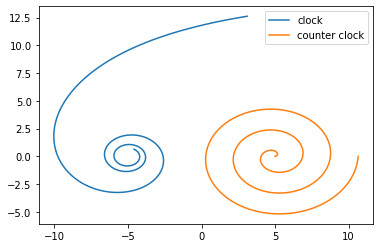

In [ ]:
    # generate toy spiral data
    orig_trajs, samp_trajs, orig_ts, samp_ts = generate_spiral2d(
        nspiral=nspiral,
        start=start,
        stop=stop,
        noise_std=noise_std,
        a=a, b=b
    )
    orig_trajs = torch.from_numpy(orig_trajs).float().to(device)
    samp_trajs = torch.from_numpy(samp_trajs).float().to(device)
    samp_ts = torch.from_numpy(samp_ts).float().to(device)

    # model
    func = LatentODEfunc(latent_dim, nhidden).to(device)
    rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nspiral).to(device)
    dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
    params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
    optimizer = optim.Adam(params, lr=lr)
    loss_meter = RunningAverageMeter()

    if dir is not None:
        if not os.path.exists(dir):
            os.makedirs(dir)
        ckpt_path = os.path.join(dir, 'ckpt.pth')
        if os.path.exists(ckpt_path):
            checkpoint = torch.load(ckpt_path)
            func.load_state_dict(checkpoint['func_state_dict'])
            rec.load_state_dict(checkpoint['rec_state_dict'])
            dec.load_state_dict(checkpoint['dec_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            orig_trajs = checkpoint['orig_trajs']
            samp_trajs = checkpoint['samp_trajs']
            orig_ts = checkpoint['orig_ts']
            samp_ts = checkpoint['samp_ts']
            print('Loaded ckpt from {}'.format(ckpt_path))

    try:
        for itr in range(1, niters + 1):
            optimizer.zero_grad()
            # backward in time to infer q(z_0)
            h = rec.initHidden().to(device)
            for t in reversed(range(samp_trajs.size(1))):
                obs = samp_trajs[:, t, :]
                print(obs.shape)
                out, h = rec.forward(obs, h)
            qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
            epsilon = torch.randn(qz0_mean.size()).to(device)
            z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

            # forward in time and solve ode for reconstructions
            pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
            pred_x = dec(pred_z)

            # compute loss
            noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
            noise_logvar = 2. * torch.log(noise_std_).to(device)
            logpx = log_normal_pdf(
                samp_trajs, pred_x, noise_logvar).sum(-1).sum(-1)
            pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
            analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                    pz0_mean, pz0_logvar).sum(-1)
            loss = torch.mean(-logpx + analytic_kl, dim=0)
            loss.backward()
            optimizer.step()
            loss_meter.update(loss.item())

            print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -loss_meter.avg))

    except KeyboardInterrupt:
        if dir is not None:
            ckpt_path = os.path.join(dir, 'ckpt.pth')
            torch.save({
                'func_state_dict': func.state_dict(),
                'rec_state_dict': rec.state_dict(),
                'dec_state_dict': dec.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'orig_trajs': orig_trajs,
                'samp_trajs': samp_trajs,
                'orig_ts': orig_ts,
                'samp_ts': samp_ts,
            }, ckpt_path)
            print('Stored ckpt at {}'.format(ckpt_path))
    print('Training complete after {} iters.'.format(itr))

    if vis:
        print('nya')
        with torch.no_grad():
            # sample from trajectorys' approx. posterior
            h = rec.initHidden().to(device)
            for t in reversed(range(samp_trajs.size(1))):
                obs = samp_trajs[:, t, :]
                print(obs.shape)
                out, h = rec.forward(obs, h)
            qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
            epsilon = torch.randn(qz0_mean.size()).to(device)
            z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
            orig_ts = torch.from_numpy(orig_ts).float().to(device)

            # take first trajectory for visualization
            z0 = z0[0]

            ts_pos = np.linspace(0., 2. * np.pi, num=2000)
            ts_neg = np.linspace(-np.pi, 0., num=2000)[::-1].copy()
            ts_pos = torch.from_numpy(ts_pos).float().to(device)
            ts_neg = torch.from_numpy(ts_neg).float().to(device)

            zs_pos = odeint(func, z0, ts_pos)
            zs_neg = odeint(func, z0, ts_neg)

            xs_pos = dec(zs_pos)
            xs_neg = torch.flip(dec(zs_neg), dims=[0])

        xs_pos = xs_pos.cpu().numpy()
        xs_neg = xs_neg.cpu().numpy()
        orig_traj = orig_trajs[0].cpu().numpy()
        samp_traj = samp_trajs[0].cpu().numpy()

        plt.figure()
        plt.plot(orig_traj[:, 0], orig_traj[:, 1],
                 'g', label='true trajectory')
        plt.plot(xs_pos[:, 0], xs_pos[:, 1], 'r',
                 label='learned trajectory (t>0)')
        plt.plot(xs_neg[:, 0], xs_neg[:, 1], 'c',
                 label='learned trajectory (t<0)')
        plt.scatter(samp_traj[:, 0], samp_traj[
                    :, 1], label='sampled data', s=3)
        plt.legend()
        plt.savefig('./vis.png', dpi=500)
        plt.show()

In [ ]:
    with torch.no_grad():
        # sample from trajectorys' approx. posterior
        h = rec.initHidden().to(device)
        for t in reversed(range(samp_trajs.size(1))):
            obs = samp_trajs[:, t, :]
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
        #orig_ts = torch.from_numpy(orig_ts).float().to(device)

            # take first trajectory for visualization
        z0 = z0[0]

        ts_pos = np.linspace(0., 2. * np.pi, num=2000)
        ts_neg = np.linspace(-np.pi, 0., num=2000)[::-1].copy()
        ts_pos = torch.from_numpy(ts_pos).float().to(device)
        ts_neg = torch.from_numpy(ts_neg).float().to(device)

        zs_pos = odeint(func, z0, ts_pos)
        zs_neg = odeint(func, z0, ts_neg)

        xs_pos = dec(zs_pos)
        xs_neg = torch.flip(dec(zs_neg), dims=[0])

        xs_pos = xs_pos.cpu().numpy()
        xs_neg = xs_neg.cpu().numpy()
        orig_traj = orig_trajs[0].cpu().numpy()
        samp_traj = samp_trajs[0].cpu().numpy()

        plt.figure()
        plt.plot(orig_traj[:, 0], orig_traj[:, 1],
                 'g', label='true trajectory')
        plt.plot(xs_pos[:, 0], xs_pos[:, 1], 'r',
                 label='learned trajectory (t>0)')
        plt.plot(xs_neg[:, 0], xs_neg[:, 1], 'c',
                 label='learned trajectory (t<0)')
        plt.scatter(samp_traj[:, 0], samp_traj[
                    :, 1], label='sampled data', s=3)
        plt.legend()
        #plt.savefig('./vis.png', dpi=500)
        plt.show()

NameError: ignored

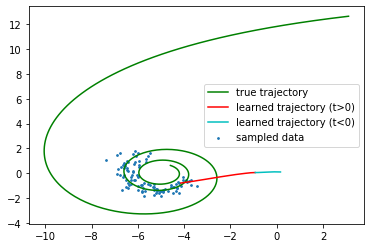

In [ ]:
plt.figure()
plt.plot(orig_traj[:, 0], orig_traj[:, 1],
                 'g', label='true trajectory')
plt.plot(xs_pos[:, 0], xs_pos[:, 1], 'r',
                 label='learned trajectory (t>0)')
plt.plot(xs_neg[:, 0], xs_neg[:, 1], 'c',
                 label='learned trajectory (t<0)')
plt.scatter(samp_traj[:, 0], samp_traj[
                    :, 1], label='sampled data', s=3)
plt.legend()
        #plt.savefig('./vis.png', dpi=500)
plt.show()

In [ ]:
samp_ts.shape

torch.Size([100])

In [ ]:
orig_ts.shape

torch.Size([500])

In [ ]:
orig_trajs.shape

torch.Size([1000, 500, 2])

In [ ]:
samp_trajs.shape

torch.Size([1000, 100, 2])

In [ ]:
latent_dim = 4
nhidden = 400
rnn_nhidden = 400
obs_dim = 1
nspiral = 2000
start = 0.
stop = 6 * np.pi
noise_std = .3
a = 0.
b = .3
niters = 200000
dir = None
ntotal = 1000
nsample = 100
device =  'cpu'
lr = 0.001
vis = True

In [ ]:
from numpy.random import default_rng

rng = default_rng()
numbers = rng.choice(20, size=10, replace=False)

In [ ]:
trset =  np.array(Training_Set)[500:4500]

In [ ]:
trtime = torch.tensor(np.linspace(500,4500,4000))

In [ ]:
np.random.normal(loc=0.0, scale=100.0, size=1)

array([63.52556035])

In [ ]:
samples = np.zeros((1,2000))
samplest = np.ones((1))*2000
samplest = np.sort(samplest)
for i in range(1):
  for j in range(1000):
    samples[i][j] = trset[1500+ j] 

In [ ]:
    func = LatentODEfunc(latent_dim, nhidden).to(device)
    rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nspiral).to(device)
    dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
    params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
    optimizer = optim.Adam(params, lr=lr)
    loss_meter = RunningAverageMeter()


In [ ]:
    orig_trajs = torch.from_numpy(trset).float().to(device)
    samp_trajs = torch.from_numpy(samples).float().to(device)
    samp_ts = torch.from_numpy(samplest).float().to(device)

    # model
    func = LatentODEfunc(latent_dim, nhidden).to(device)
    rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nspiral).to(device)
    dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
    params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
    optimizer = optim.Adam(params, lr=lr)
    loss_meter = RunningAverageMeter()

    if dir is not None:
        if not os.path.exists(dir):
            os.makedirs(dir)
        ckpt_path = os.path.join(dir, 'ckpt.pth')
        if os.path.exists(ckpt_path):
            checkpoint = torch.load(ckpt_path)
            func.load_state_dict(checkpoint['func_state_dict'])
            rec.load_state_dict(checkpoint['rec_state_dict'])
            dec.load_state_dict(checkpoint['dec_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            orig_trajs = checkpoint['orig_trajs']
            samp_trajs = checkpoint['samp_trajs']
            orig_ts = checkpoint['orig_ts']
            samp_ts = checkpoint['samp_ts']
            print('Loaded ckpt from {}'.format(ckpt_path))

    try:
        for itr in range(1, niters + 1):
            optimizer.zero_grad()
            # backward in time to infer q(z_0)
            h = rec.initHidden().to(device)
            for t in reversed(range(samp_trajs.size(0))):
                obs = samp_trajs[t,:].reshape(nspiral,1)
                out, h = rec.forward(obs, h)
            qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
            epsilon = torch.randn(qz0_mean.size()).to(device)
            z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

            # forward in time and solve ode for reconstructions
            pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
            pred_x = dec(pred_z)

            # compute loss
            noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
            noise_logvar = 2. * torch.log(noise_std_).to(device)
            logpx = log_normal_pdf(
                samp_trajs, pred_x, noise_logvar).sum(-1).sum(-1)
            pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
            analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                    pz0_mean, pz0_logvar).sum(-1)
            loss = torch.mean(-logpx + analytic_kl, dim=0)
            loss.backward()
            optimizer.step()
            loss_meter.update(loss.item())

            print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -loss_meter.avg))

    except KeyboardInterrupt:
        if dir is not None:
            ckpt_path = os.path.join(dir, 'ckpt.pth')
            torch.save({
                'func_state_dict': func.state_dict(),
                'rec_state_dict': rec.state_dict(),
                'dec_state_dict': dec.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'orig_trajs': orig_trajs,
                'samp_trajs': samp_trajs,
                'orig_ts': orig_ts,
                'samp_ts': samp_ts,
            }, ckpt_path)
            print('Stored ckpt at {}'.format(ckpt_path))
    print('Training complete after {} iters.'.format(itr))


Выходные данные были обрезаны до нескольких последних строк (5000).
Iter: 8239, running avg elbo: -694491679146.4478
Iter: 8240, running avg elbo: -694491573608.7433
Iter: 8241, running avg elbo: -694491476335.3759
Iter: 8242, running avg elbo: -694491415424.1821
Iter: 8243, running avg elbo: -694491313834.4203
Iter: 8244, running avg elbo: -694491205396.2361
Iter: 8245, running avg elbo: -694491133431.8737
Iter: 8246, running avg elbo: -694491019588.7549
Iter: 8247, running avg elbo: -694490902951.9073
Iter: 8248, running avg elbo: -694490802554.7083
Iter: 8249, running avg elbo: -694490712991.8811
Iter: 8250, running avg elbo: -694490640708.6823
Iter: 8251, running avg elbo: -694490559973.2755
Iter: 8252, running avg elbo: -694490510847.1427
Iter: 8253, running avg elbo: -694490446483.6312
Iter: 8254, running avg elbo: -694490365724.3949
Iter: 8255, running avg elbo: -694490242518.9910
Iter: 8256, running avg elbo: -694490196567.4010
Iter: 8257, running avg elbo: -694490119618.0469
I

In [ ]:
testtime = np.linspace(-1000,2000,3000)

In [ ]:
with torch.no_grad():
        # sample from trajectorys' approx. posterior
        h = rec.initHidden().to(device)
        for t in reversed(range(samp_trajs.size(0))):
            obs = samp_trajs[t,:].reshape(nspiral,1)
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
        #orig_ts = torch.from_numpy(orig_ts).float().to(device)

            # take first trajectory for visualization
        z0 = z0[0]

        ts_pos = np.linspace(3500, 3600, num=100)
        ts_neg = np.linspace(1400, 1500, num=100)[::-1].copy()
        ts_pos = torch.from_numpy(ts_pos).float().to(device)
        ts_neg = torch.from_numpy(ts_neg).float().to(device)

        zs_pos = odeint(func, z0, ts_pos)
        zs_neg = odeint(func, z0, ts_neg)

        xs_pos = dec(zs_pos)
        xs_neg = torch.flip(dec(zs_neg), dims=[0])

        xs_pos = xs_pos.cpu().numpy()
        xs_neg = xs_neg.cpu().numpy()
        #orig_traj = orig_trajs[0].cpu().numpy()
        #samp_traj = samp_trajs[0].cpu().numpy()



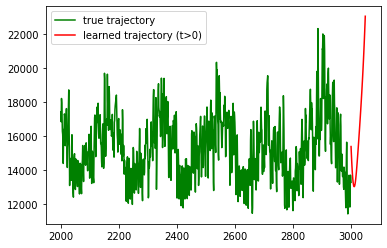

In [ ]:
        plt.figure()
        plt.plot(np.linspace(2000,3000,1000),trset[2000:3000], 
                 'g', label='true trajectory')
        plt.plot(ts_pos[0:50],xs_pos[0:50],  'r',
                 label='learned trajectory (t>0)')
        #plt.plot(ts_neg[980:1000], xs_neg[980:1000],  'c',
                 #label='learned trajectory (t<0)')

        plt.legend()
        #plt.savefig('./vis.png', dpi=500)
        plt.show()

**Часть 2.**

In [ ]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = 0
def ode_solve(z0, t0, t1, f):
    """
    Простейший метод эволюции ОДУ - метод Эйлера
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(RNNEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.rnn = nn.GRU(input_dim+1, hidden_dim)
        self.hid2lat = nn.Linear(hidden_dim, 2*latent_dim)

    def forward(self, x, t):
        # Concatenate time to input
        t = t.clone()
        t[1:] = t[:-1] - t[1:]
        t[0] = 0.
        xt = torch.cat((x, t), dim=-1)

        _, h0 = self.rnn(xt.flip((0,)))  # Reversed
        # Compute latent dimension
        z0 = self.hid2lat(h0[0])
        z0_mean = z0[:, :self.latent_dim]
        z0_log_var = z0[:, self.latent_dim:]
        return z0_mean, z0_log_var
class NeuralODEDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(NeuralODEDecoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        func = NNODEF(latent_dim, hidden_dim, time_invariant=True)
        self.ode = NeuralODE(func)
        self.l2h = nn.Linear(latent_dim, hidden_dim)
        self.h2o = nn.Linear(hidden_dim, output_dim)

    def forward(self, z0, t):
        zs = self.ode(z0, t, return_whole_sequence=True)

        hs = self.l2h(zs)
        xs = self.h2o(hs)
        return xs
class ODEVAE(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(ODEVAE, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder = RNNEncoder(output_dim, hidden_dim, latent_dim)
        self.decoder = NeuralODEDecoder(output_dim, hidden_dim, latent_dim)

    def forward(self, x, t, MAP=False):
        z_mean, z_log_var = self.encoder(x, t)
        if MAP:
            z = z_mean
        else:
            z = z_mean + torch.randn_like(z_mean) * torch.exp(0.5 * z_log_var)
        x_p = self.decoder(z, t)
        return x_p, z, z_mean, z_log_var

    def generate_with_seed(self, seed_x, t):
        seed_t_len = seed_x.shape[0]
        z_mean, z_log_var = self.encoder(seed_x, t[:seed_t_len])
        x_p = self.decoder(z_mean, t)
        return x_p
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # метод grad автоматически суммирует градие*н*ты для всех элементов батча, надо expand их обратно 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Динамика аугментированной системы, которую надо эволюционировать обратно во времени
        def augmented_dynamics(aug_z_i, t_i):
            """
            Тензоры здесь - это срезы по времени
            t_i - тензор с размерами: bs, 1
            aug_z_i - тензор с размерами: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # игнорируем параметры и время

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz для удобства
        with torch.no_grad():
            ## Создадим плейсхолдеры для возвращаемых градиентов
            # Распространенные назад сопряженные состояния, которые надо поправить градиентами от наблюдений
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # В отличие от z и p, нужно вернуть градиенты для всех моментов времени
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Рассчитаем прямые градиенты от наблюдений
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Подправим ими сопряженные состояния
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Упакуем аугментированные переменные в вектор
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Решим (эволюционируем) аугментированную систему назад во времени
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Распакуем переменные обратно из решенной системы
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Подправим сопряженное состояние в нулевой момент времени прямыми градиентами
            # Вычислим прямые градиенты
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Подправим
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

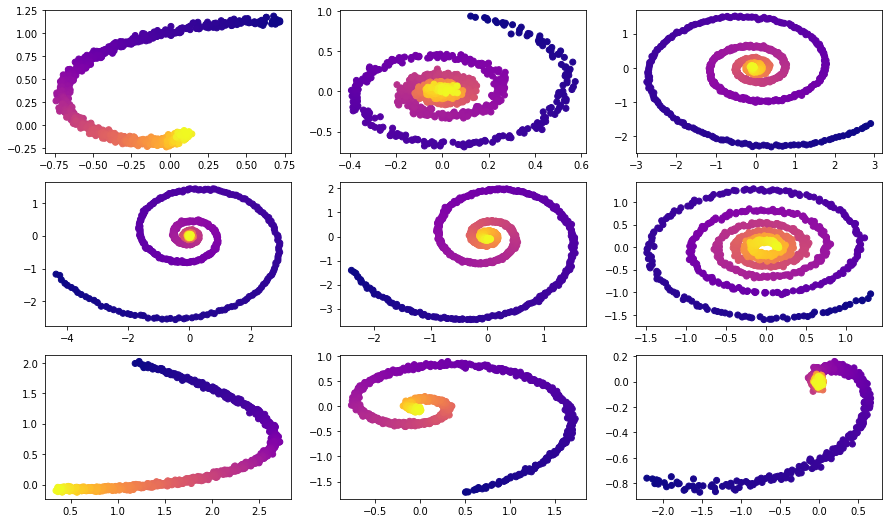

In [ ]:
t_max = 6.29*5
n_points = 1000
noise_std = 0.02

num_spirals = 1000

index_np = np.arange(0, n_points, 1, dtype=np.int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]] * num_spirals)
times = torch.from_numpy(times_np[:, :, None]).to(torch.float32)

# Generate random spirals parameters
normal01 = torch.distributions.Normal(0, 1.0)

x0 = Variable(normal01.sample((num_spirals, 2))) * 2.0  

W11 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W22 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W21 = -1.0 * normal01.sample((num_spirals,)).abs()
W12 =  1.0 * normal01.sample((num_spirals,)).abs()

xs_list = []
for i in range(num_spirals):
    if i % 2 == 1: #  Make it counter-clockwise
        W21, W12 = W12, W21

    func = LinearODEF(Tensor([[W11[i], W12[i]], [W21[i], W22[i]]]))
    ode = NeuralODE(func)

    xs = ode(x0[i:i+1], times[:, i:i+1], return_whole_sequence=True)
    xs_list.append(xs)


orig_trajs = torch.cat(xs_list, dim=1).detach()
samp_trajs = orig_trajs + torch.randn_like(orig_trajs) * noise_std
samp_ts = times
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.scatter(samp_trajs[:, 50+i, 0], samp_trajs[:, 50+i, 1], c=samp_ts[:, 50+i, 0], cmap=cm.plasma)
plt.show()

In [ ]:
torch.tensor(trset[1500+i])

tensor([15086.3333], dtype=torch.float64)

In [ ]:
for i in range(1000):
  samp_trajs[i,7,:][1] = (torch.tensor(trset[1500+i])/500 - 20)/2
  samp_trajs[i,7,:][0] = i/250

In [ ]:
def to_np(x):
    return x.detach().cpu().numpy()

In [ ]:
import numpy.random as npr
from numpy import save

def gen_batch(batch_size, n_sample=100):
    n_batches = samp_trajs.shape[1] // batch_size
    time_len = samp_trajs.shape[0]
    n_sample = min(n_sample, time_len)
    for i in range(n_batches):
        if n_sample > 0:
            t0_idx = npr.multinomial(1, [1. / (time_len - n_sample)] * (time_len - n_sample))
            t0_idx = np.argmax(t0_idx)
            tM_idx = t0_idx + n_sample
        else:
            t0_idx = 0
            tM_idx = time_len

        frm, to = batch_size*i, batch_size*(i+1)
        yield samp_trajs[t0_idx:tM_idx, frm:to], samp_ts[t0_idx:tM_idx, frm:to]

In [ ]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

Epoch 1631


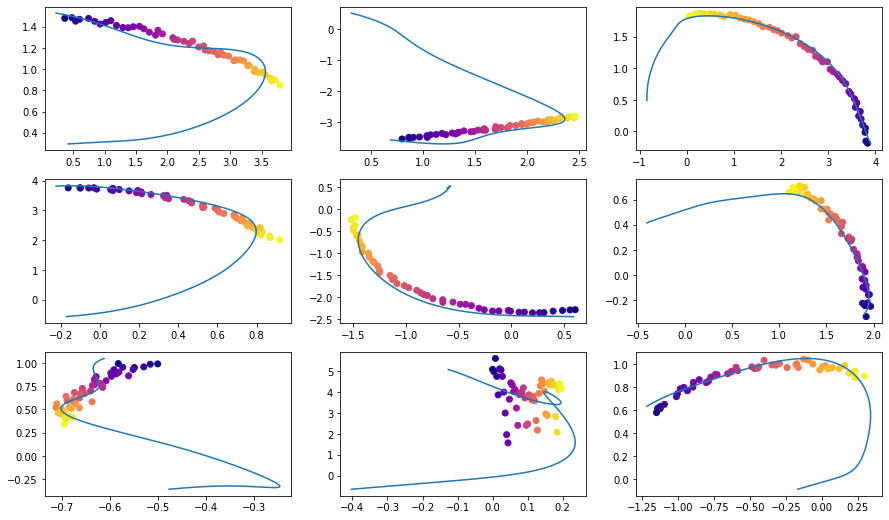

23.445972633361816 17.030327796936035


In [ ]:
vae = ODEVAE(2, 64, 10)
optim = torch.optim.Adam(vae.parameters(), betas=(0.9, 0.999), lr=0.001)
lot_traj_idx = 1
plot_traj = orig_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_obs = samp_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_ts = samp_ts[:, plot_traj_idx:plot_traj_idx+1]
if use_cuda:
    plot_traj = plot_traj.cuda()
    plot_obs = plot_obs.cuda()
    plot_ts = plot_ts.cuda()

if preload:
    vae.load_state_dict(torch.load("models/vae_spirals.sd"))
for epoch_idx in range(n_epochs):
    losses = []
    train_iter = gen_batch(batch_size)
    for x, t in train_iter:
        optim.zero_grad()
        if use_cuda:
            x, t = x.cuda(), t.cuda()

        max_len = np.random.choice([30, 50, 100])
        permutation = np.random.permutation(t.shape[0])
        np.random.shuffle(permutation)
        permutation = np.sort(permutation[:max_len])

        x, t = x[permutation], t[permutation]

        x_p, z, z_mean, z_log_var = vae(x, t)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), -1)
        loss = 0.5 * ((x-x_p)**2).sum(-1).sum(0) / noise_std**2 + kl_loss
        loss = torch.mean(loss)
        loss /= max_len
        loss.backward()
        optim.step()
        losses.append(loss.item())

    

    frm, to, to_seed = 0, 200, 50
    seed_trajs = samp_trajs[frm:to_seed]
    ts = samp_ts[frm:to]
    if use_cuda:
        seed_trajs = seed_trajs.cuda()
        ts = ts.cuda()

    samp_trajs_p = to_np(vae.generate_with_seed(seed_trajs, ts))
    #if(epoch_idx % 100 == 0):
    print(f"Epoch {epoch_idx}")
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
      ax.scatter(to_np(seed_trajs[:, i, 0]), to_np(seed_trajs[:, i, 1]), c=to_np(ts[frm:to_seed, i, 0]), cmap=cm.plasma)
      #ax.plot(to_np(orig_trajs[frm:to, i, 0]), to_np(orig_trajs[frm:to, i, 1]))
      ax.plot(samp_trajs_p[:, i, 0], samp_trajs_p[:, i, 1])
    i = 7
    save('0.npy',to_np(seed_trajs[:, i, 0]))
    save('1.npy',to_np(seed_trajs[:, i, 1]))
    save('c.npy',to_np(ts[frm:to_seed, i, 0]))
    save('i.npy',np.array(epoch_idx))
    plt.show()
    print(np.mean(losses), np.median(losses))
    clear_output(wait=True)

In [ ]:

# load numpy array from npy file
from numpy import load
# load array
data = load('i.npy')
data

array(7)

In [ ]:
spiral_0_idx = 3
spiral_1_idx = 6

homotopy_p = Tensor(np.linspace(0., 1., 10)[:, None])
vae = vae
if use_cuda:
    homotopy_p = homotopy_p.cuda()
    vae = vae.cuda()

spiral_0 = orig_trajs[:, spiral_0_idx:spiral_0_idx+1, :]
spiral_1 = orig_trajs[:, spiral_1_idx:spiral_1_idx+1, :]
ts_0 = samp_ts[:, spiral_0_idx:spiral_0_idx+1, :]
ts_1 = samp_ts[:, spiral_1_idx:spiral_1_idx+1, :]
if use_cuda:
    spiral_0, ts_0 = spiral_0.cuda(), ts_0.cuda()
    spiral_1, ts_1 = spiral_1.cuda(), ts_1.cuda()

z_cw, _ = vae.encoder(spiral_0, ts_0)
z_cc, _ = vae.encoder(spiral_1, ts_1)

homotopy_z = z_cw * (1 - homotopy_p) + z_cc * homotopy_p

t = torch.from_numpy(np.linspace(0, 6*np.pi, 200))
t = t[:, None].expand(200, 10)[:, :, None].cuda()
t = t.cuda() if use_cuda else t
hom_gen_trajs = vae.decoder(homotopy_z, t)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.plot(to_np(hom_gen_trajs[:, i, 0]), to_np(hom_gen_trajs[:, i, 1]))
plt.show()